## Training

1) Get text and durations in batches
2) Get spectrograms in batches

In [1]:
from fastai.data.all import *
import librosa
import tgt

In [2]:
path = Path("../data/LJSpeech-1.1/")

In [3]:
get_audio_files = FileGetter(extensions='.wav')
files = get_audio_files(path)
files

(#13083) [Path('../data/LJSpeech-1.1/wavs/LJ045-0006.wav'),Path('../data/LJSpeech-1.1/wavs/LJ044-0106.wav'),Path('../data/LJSpeech-1.1/wavs/LJ037-0019.wav'),Path('../data/LJSpeech-1.1/wavs/LJ003-0245.wav'),Path('../data/LJSpeech-1.1/wavs/LJ019-0137.wav'),Path('../data/LJSpeech-1.1/wavs/LJ030-0115.wav'),Path('../data/LJSpeech-1.1/wavs/LJ018-0358.wav'),Path('../data/LJSpeech-1.1/wavs/LJ021-0041.wav'),Path('../data/LJSpeech-1.1/wavs/LJ019-0185.wav'),Path('../data/LJSpeech-1.1/wavs/LJ017-0010.wav')...]

In [4]:
samples = L(map(librosa.load, files[:5])).map(lambda x: x[0])

In [5]:
n_fft = 2048 # Adjusts Resolution
n_bins = 80 # Height
hop_length = 512 # Width = time * sample rate / hop_length
sample_rate = 22050

In [6]:
melspectrogram = lambda y: librosa.feature.melspectrogram(y=y, sr=sample_rate, n_fft=n_fft, 
                         hop_length=hop_length, n_mels=n_bins)

In [7]:
mel_samples = samples.map(melspectrogram)

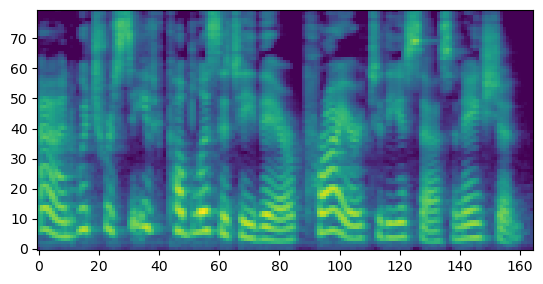

In [8]:
plt.imshow(librosa.power_to_db(mel_samples[0]), origin='lower');

In [9]:
len(samples[0]) / hop_length

164.806640625

In [10]:
tgt_files = files.map(lambda x: x.with_suffix('.TextGrid'))
samples_tgt = tgt_files[:5].map(tgt.io.read_textgrid)
samples_tiers = samples_tgt.map(lambda x: x.get_tier_by_name("phones"))

In [11]:
def get_phoneme_duration(tiers, sr, hop_length):
    phones, durations = [], []
    for interval in tiers:
        start, end, phoneme = interval.start_time, interval.end_time, interval.text
        duration = int(end*sr/hop_length - start*sr/hop_length)
        phones.append(phoneme)
        durations.append(duration)
    return phones, durations

In [12]:
sample_phones, sample_durations = zip(*samples_tiers.map(partial(get_phoneme_duration, 
                                              sr=sample_rate, hop_length=hop_length)))

In [13]:
sample_durations = L(sample_durations).map(tensor)

In [14]:
from torch.nn.utils.rnn import pad_sequence

In [15]:
pad_sequence(sample_durations, batch_first=True, padding_value=0).shape

torch.Size([5, 103])

In [16]:
path_vocab = Path("../data/CMUDict/cmudict-0.7b.symbols.txt")

In [17]:
vocab = L(path_vocab.open().readlines()).map(lambda x: x.strip())
specials = L(["<pad>", "spn"])
vocab = vocab + specials
vocab

(#86) ['AA','AA0','AA1','AA2','AE','AE0','AE1','AE2','AH','AH0'...]

In [18]:
pho2idx = {phoneme: i for i, phoneme in enumerate(vocab)}
pho2idx[vocab[1]]

1

In [19]:
sample_num = list(L(sample_phones).map(lambda x: tensor(L(x).map(pho2idx))))
sample_num[:2], L(map(len, sample_num))

([tensor([ 9, 55, 26, 80, 45, 25, 66,  9, 67, 49, 79, 26, 65,  9, 24, 53, 45, 67,
           9, 69, 48, 27, 30, 66, 65, 66, 22, 33, 69, 77, 27,  9,  9, 67,  7, 67,
           9, 55, 38, 68,  9, 55]),
  tensor([ 9, 55, 26, 24, 30, 55, 51,  9, 54,  9, 55, 51, 38, 26, 38, 79,  9, 67,
           2, 55, 33, 31, 66, 48, 54, 30, 54, 24, 33, 68, 46, 65, 52,  2, 66, 26,
          82, 44, 55, 42, 45, 82, 55,  3, 55,  9, 41, 82, 45, 67, 69,  9, 55, 69,
          55, 77, 14, 66, 53, 50, 55, 82, 25,  6, 65, 69, 33, 10, 79, 27,  9, 40,
          30, 66, 65, 53, 38, 40, 14, 66, 52, 81, 77, 24,  9, 52,  9, 54, 45, 69,
          48])],
 (#5) [42,91,96,79,103])

In [20]:
padding_value = pho2idx["<pad>"]
max_idx = tensor(sample_durations.map(len)).argmax().item()

In [21]:
sample_num[max_idx] = torch.cat((sample_num[max_idx], torch.tensor([padding_value])))

In [22]:
pad_sequence(sample_num, batch_first=True, padding_value=padding_value).shape

torch.Size([5, 104])

In [23]:
mel_samples.map(torch.from_numpy).map(lambda x: x.T)[:1]

(#1) [tensor([[5.5823e-05, 4.6921e-04, 2.0621e-03,  ..., 3.8611e-07, 4.0185e-07,
         1.0379e-07],
        [7.3976e-04, 3.1259e-03, 7.7087e-03,  ..., 9.8980e-07, 1.0736e-06,
         4.0474e-07],
        [1.4382e-03, 3.7571e-03, 9.4639e-03,  ..., 1.6006e-06, 9.4611e-07,
         1.4576e-06],
        ...,
        [4.7799e-05, 2.2643e-04, 1.2149e-03,  ..., 4.3920e-07, 3.0743e-07,
         6.0274e-08],
        [4.4250e-05, 1.1363e-04, 6.5289e-04,  ..., 5.5502e-07, 2.8747e-07,
         8.1673e-08],
        [3.3191e-05, 1.5425e-04, 4.4231e-04,  ..., 4.7729e-07, 2.5025e-07,
         7.3148e-08]])]

torch.Size([5, 80, 377])

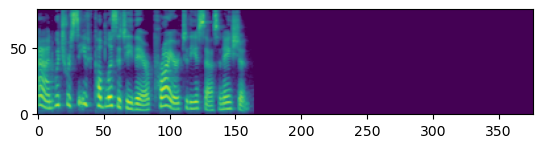

In [24]:
sample_padded = pad_sequence(mel_samples.map(torch.from_numpy).map(lambda x: x.T), 
                             batch_first=True).transpose(1, 2)
plt.imshow(librosa.power_to_db(sample_padded[0]), origin="lower"); sample_padded.shape

In [25]:
sum(sample_durations[0]), sample_padded.size(-1)

(tensor(145), 377)

Since the duration should be equal to the width of the melspectrogram we have to adjust the duration amount for the padded part

In [26]:
sample_durations.map(lambda x: x.shape)

(#5) [torch.Size([42]),torch.Size([91]),torch.Size([96]),torch.Size([79]),torch.Size([103])]

In [27]:
max_idx = tensor(sample_durations.map(len)).argmax().item()
max_idx, sample_durations[max_idx].shape

(4, torch.Size([103]))

In [28]:
sample_durations[max_idx] = torch.cat((sample_durations[max_idx], torch.tensor([0])))

In [29]:
sample_durations[:1]

(#1) [tensor([8, 1, 3, 1, 1, 6, 1, 1, 6, 5, 2, 3, 3, 2, 3, 3, 2, 3, 2, 4, 4, 3, 6, 3,
        8, 2, 6, 6, 5, 1, 1, 3, 2, 5, 5, 5, 1, 1, 5, 6, 3, 4])]

In [30]:
sample_dur_padded = pad_sequence(sample_durations, batch_first=True, padding_value=0)
sample_dur_padded.shape

torch.Size([5, 104])

In [31]:
for i, duration in enumerate(sample_durations):
    amt = sample_padded.size(-1) - duration.sum().item()
    sample_dur_padded[i, -1] = amt
    print(sample_dur_padded[i].sum()) 

tensor(377)
tensor(377)
tensor(377)
tensor(377)
tensor(377)


In [32]:
padded_durations = tensor([sample_padded.size(-1) - duration.sum().item() 
                    for duration in sample_durations])

padded_durations

tensor([232,  91,  46,  89,  55])

In [33]:
sample_dur_padded[:, -1] = padded_durations

In [34]:
sample_dur_padded[:, -1]

tensor([232,  91,  46,  89,  55])

In [ ]:
tens = tensor([1,2,3,3,3,2,1])
max_val = 0
max_idxs = []
for i in range(len(tens)):
    val = tens[i].item()
    if val > max_val:
        max_val = val
        max_idxs = [i]
    elif val == max_val:
        max_idxs.append(i)

In [ ]:
max_idxs

In [ ]:
def argmax_all(tens):
    max_val = 0
    max_idxs = []
    for i in range(len(tens)):
        val = tens[i].item()
        if val > max_val:
            max_val = val
            max_idxs = [i]
        elif val == max_val:
            max_idxs.append(i)
    return max_idxs

In [ ]:
argmax_all(torch.randint(100, (1000,)))

In [ ]:
sample_dur_padded.sum(dim=-1), sample_padded.size(-1)

### Putting it together

In [ ]:
from fastai.data.all import *
import librosa
import tgt
from torch.nn.utils.rnn import pad_sequence

In [ ]:
n_fft = 2048 # Adjusts Resolution
# Width = time * sample_rate / hop_length
hop_length = 512 
sample_rate = 22050
n_bins = 80 # Height

#### Functions

In [ ]:
get_audio_files = FileGetter(extensions='.wav')

melspectrogram = partial(librosa.feature.melspectrogram, n_fft=n_fft, 
                         hop_length=hop_length, n_mels=n_bins)

def get_tiers(path): return tgt.io.read_textgrid(path).get_tier_by_name("phones")

def get_phoneme_duration(tiers, sr, hop_length):
    '''
    tiers: List[tgt.core.IntervalTier]
    sr: int
    hop_length: int
    '''
    phones, durations = [], []
    for interval in tiers:
        start, end, phoneme = interval.start_time, interval.end_time, interval.text
        duration = int(end*sr/hop_length - start*sr/hop_length)
        phones.append(phoneme)
        durations.append(duration)
    return phones, durations

In [ ]:
def argmax_all(tens):
    max_val = 0
    max_idxs = []
    for i in range(len(tens)):
        val = tens[i].item()
        if val > max_val:
            max_val = val
            max_idxs = [i]
        elif val == max_val:
            max_idxs.append(i)
    return max_idxs

In [ ]:
def pad_max_seq(seq, pad_val=0, pad_len=1):
    '''
    seq: List[tensors]
    pad_val: int
    pad_len: int
    '''
    seq_pad = L(seq[:])
    max_idxs = argmax_all(tensor(seq_pad.map(len)))
    for idx in max_idxs:
        seq_pad[idx] = torch.cat((seq_pad[idx], torch.tensor([pad_val]*pad_len)))
    return seq_pad

def pad_mels(mels):
    '''mels: List[tensor]'''
    return pad_sequence(L(mels).map(lambda x: x.T), batch_first=True).transpose(1, 2)

def pad_phones(nums, pad_num): 
    '''
    nums: List[tensor]
    pad_num: int
    '''
    return pad_sequence(nums, batch_first=True, padding_value=pad_num)

def pad_durations(durations, mel_len):
    '''
    durations: List[tensors]
    mel_len: int
    '''
    padded_duration = pad_sequence(durations, batch_first=True)
    padded_duration_amount = [mel_len - dur.sum().item() for dur in durations]
    padded_duration[:, -1] = tensor(padded_duration_amount)
    return padded_duration

#### Batching

In [ ]:
path = Path("../data/LJSpeech-1.1/")
path_vocab = Path("../data/CMUDict/cmudict-0.7b.symbols.txt")

In [ ]:
files = get_audio_files(path)[:5]
files_tg = files.map(lambda x: x.with_suffix('.TextGrid'))
vocab = L(path_vocab.open().readlines()).map(lambda x: x.strip())

In [ ]:
specials = L(["<pad>", "spn"])
vocab = vocab + specials
pho2idx = {phoneme: i for i, phoneme in enumerate(vocab)}

In [ ]:
wavs = L(map(partial(librosa.load, sr=sample_rate), files)).map(lambda x: x[0])
mels = wavs.map(melspectrogram)
mels_batched = pad_mels(mels.map(tensor))

In [ ]:
pad_num, mel_len = pho2idx["<pad>"], mels_batched.size(-1)
tiers = files_tg.map(get_tiers)
phones, durations = zip(*tiers.map(partial(get_phoneme_duration, 
                                           sr=sample_rate, hop_length=hop_length)))

In [ ]:
phones_nums = pad_max_seq(L(phones).map(lambda x: tensor(L(x).map(pho2idx))))
phones_batched = pad_phones(phones_nums, pad_num) 

In [ ]:
durations_batched = pad_durations(pad_max_seq(L(durations).map(tensor)), mel_len)

In [ ]:
assert phones_batched.shape == durations_batched.shape
assert (durations_batched.sum(dim=-1) == mel_len).all()

Need to extended padding by one extra to account for the mel padding duration for phoneme and durations

#### Testing

In [ ]:
from modules import FastSpeech

In [ ]:
model = FastSpeech(len(vocab), 32, n_bins, 8, 6)
out = model(phones_batched, durations_batched, 1)
out.shape

In [ ]:
plt.imshow(librosa.power_to_db(out[0].detach().numpy()), origin="lower");

In [ ]:
plt.imshow(librosa.power_to_db(mels_batched[0]), origin='lower');

In [ ]:
F.mse_loss(out[0], mels_batched[0])

#### Dataset

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class TTSDataset(Dataset):
    def __init__(self, path_data, path_vocab, sample_rate=22050, 
                 n_fft=2048, hop_length=512, n_bins=80):
        self.files = get_audio_files(path_data)
        self.files_tg = self.files.map(lambda x: x.with_suffix('.TextGrid'))
        
        self.vocab = L(path_vocab.open().readlines()).map(lambda x: x.strip())
        self.vocab = vocab + L(["<pad>", "spn"])
        self.pho2idx = {phoneme: i for i, phoneme in enumerate(vocab)}
        self.pad_num = pho2idx["<pad>"]
        
        
        self.load_audio = partial(librosa.load, sr=sample_rate)
        self.melspectrogram = partial(librosa.feature.melspectrogram, n_fft=n_fft, 
                                      hop_length=hop_length, n_mels=n_bins)
        self.get_phoneme_duration = partial(get_phoneme_duration, sr=sample_rate, 
                                            hop_length=hop_length)
        
    def __len__(self): return len(self.files)
    
    def __getitem__(self, idx):
        wav = self.load_audio(self.files[idx])[0]
        tiers = get_tiers(self.files_tg[idx])
        phones, durations = self.get_phoneme_duration(tiers)
        
        mel = tensor(self.melspectrogram(y=wav))
        nums = tensor(L(phones).map(pho2idx))
        durations = tensor(durations)
        
        return mel, nums, durations

In [ ]:
ds = TTSDataset(path, path_vocab, sample_rate, n_fft, hop_length, n_bins)

In [ ]:
list(map(lambda x: x.shape, (ds[123])))

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
def collate_fn(inp, pad_num):
    mels, phones, durations = zip(*inp)

    mels_batched = pad_mels(mels)
    mel_len = mels_batched.size(-1)
    
    phones_batched = pad_phones(pad_max_seq(phones), pad_num)
    durations_batched = pad_durations(pad_max_seq(durations), mel_len)
    
    assert phones_batched.shape == durations_batched.shape
    assert (durations_batched.sum(dim=-1) == mel_len).all()
    
    return mels_batched, phones_batched, durations_batched

In [ ]:
dl = DataLoader(ds, 64, collate_fn=partial(collate_fn, pad_num=ds.pad_num))

In [ ]:
list(map(lambda x: x.shape, first(dl)))